# **Attribute-conditioned Cartoon Face Generation with GAN + diversity-aware RL**

In this notebook, we train a DCGAN-style generator and discriminator on the CartoonSet100k dataset (loaded section-by-section to fit Colab T4 limits). Each image has a paired CSV describing facial attributes (e.g., eye_angle, hair, face_color). We first train the GAN to generate `64x64` cartoon faces, then freeze the GAN and train an RL agent that steers the generator’s latent code toward requested attributes while explicitly encouraging sample diversity.

#### **The pipeline is designed for speed and stability on Colab:**

* Data is copied from Google Drive to local /content to reduce I/O overhead.
* The dataset is indexed efficiently (using a limited scan per folder while debugging).
* DataLoader uses `num_workers=2` with Colab-safe settings to avoid worker shutdown crashes.
* Evaluation includes FID (InceptionV3 features), LPIPS pair mining.

#### **Outputs saved by the notebook:**

* Trained weights (generator, discriminator, classifier, RL agent) <a href="https://drive.google.com/drive/folders/1Qm-Wva1TIN-R2o6KAjnWxEvhSzW5ndoS?usp=sharing"> Link </a>
*  A final folder of generated images for the contest. <a href="https://drive.google.com/drive/folders/1dpSKXJ4LvzXpIDXqS6pQNzCU2gXiZFPQ?usp=sharing"> Link </a>



## Installing Dependencies

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
!pip -q install tqdm pillow torchmetrics lpips pyyaml pandas scipy

import os
import torch
import torch.multiprocessing as mp

# Colab-safe multiprocessing
try:
    mp.set_start_method("spawn", force=True)
except RuntimeError:
    pass

# Copy dataset to local SSD (faster than Drive)
!rsync -ah --info=progress2 /content/drive/MyDrive/GAN/cartoonset100k/ /content/cartoonset100k/

print("Local dataset ready at /content/cartoonset100k")
print("cuda:", torch.cuda.is_available())


              0   0%    0.00kB/s    0:00:00 (xfr#0, ir-chk=20000/140041)

In [ ]:
!pip -q install torch-fidelity torchmetrics[image]

## Setting Configuration Variables in config.yaml

In this cell, we define all the essential hyperparameters and runtime settings for our project. These settings control the training process, dataset indexing, evaluation, and RL agent behavior. Due to **extremely limited access to T4 GPUs on Colab** and the **high overhead for copying large datasets from Google Drive**, we are using only a small subset of the full dataset for now. Here's the detailed configuration:

- **Dataset Usage**:  
  We use **only 2 subsections** of the dataset (each containing 500 images and corresponding CSVs) for a total of **1000 images**. This subset is selected to **avoid memory and time limitations**. The full dataset contains 10 subsections, but using all would be too slow and memory-intensive in the current environment.

- **T4 GPU Limitations**:  
  Due to limited T4 VRAM on Colab, working with a smaller dataset ensures that the batch size and memory usage remain manageable. This also minimizes the time spent on copying data from Google Drive to Colab.

- **Scalability**:  
  Once the training model is working well with this smaller subset, we can scale up to process all 10 subsections by increasing the `subsec_count` and `scan_limit_per_folder`.



In [1]:
%%writefile config.yaml
system:
  seed: 42
  device: "cuda"
  student_id: "610301189"

data:
  dataset_path: "/content/cartoonset100k"
  index_file: "dataset_index.csv"
  image_size: 64
  batch_size: 64
  num_workers: 2
  subsec_count: 2            # set to 10 for full dataset
  scan_limit_per_folder: 500 # set to 10000 for full indexing
  attributes: ["eye_angle", "chin_length", "eyebrow_shape", "eyebrow_thickness", "face_shape", "hair", "face_color", "hair_color", "glasses"]

gan:
  latent_dim: 100
  feature_maps: 64
  lr_g: 0.0002
  lr_d: 0.0002
  beta1: 0.5
  epochs: 10
  label_smoothing: 0.9

rl:
  lr_agent: 0.001
  gamma: 0.99
  rl_epochs: 10
  alpha_quality: 1.0
  alpha_meta: 2.0

eval:
  fid_real_batches: 10
  fid_fake_batches: 10
  lpips_pairs: 200
  generate_count: 2000


Writing config.yaml


## Data utilities: reproducible setup, dataset indexing, and a DataLoader

This cell implements all dataset-side utilities used throughout the notebook:

- Reproducibility helpers (seeding Python/NumPy/PyTorch)
- Image preprocessing to the GAN’s expected input range [-1, 1]
- CartoonDataset: builds an index by scanning a limited number of CSV files per subsection and mapping attribute values to class indices
- DataLoader: configured for Colab with num_workers=2 to speed up loading, while keeping settings stable under notebook re-runs

Important note: we intentionally rescan and rebuild the index each run to match our current limited-subset workflow (2 subsections × 500 samples each) and to avoid stale index issues when we change scan limits or subset count.


In [2]:
%%writefile utils.py
import os
import glob
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import yaml
from tqdm import tqdm

def load_config(path="config.yaml"):
    with open(path, "r") as f:
        return yaml.safe_load(f)

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def preprocess(image: Image.Image, image_size: int) -> torch.Tensor:
    img = image.resize((image_size, image_size), Image.BILINEAR)
    img_np = np.array(img).astype(np.float32)
    img_np = (img_np / 127.5) - 1.0
    img_np = img_np.transpose(2, 0, 1)  # HWC -> CHW
    return torch.from_numpy(img_np)

class CartoonDataset(Dataset):
    def __init__(self, config):
        self.root_dir = config["data"]["dataset_path"]
        self.image_size = config["data"]["image_size"]
        self.target_attributes = config["data"]["attributes"]
        self.index_file = config["data"].get("index_file", "dataset_index.csv")
        self.subsec_count = int(config["data"].get("subsec_count", 10))
        self.scan_limit_per_folder = int(config["data"].get("scan_limit_per_folder", 500))

        # Force rescan each run (your current behavior)
        if os.path.exists(self.index_file):
            print("Removing old index file to force rescan...")
            os.remove(self.index_file)

        print(f"Indexing dataset at: {self.root_dir}")
        self.df = self._create_index()

        if len(self.df) > 0:
            self.df.to_csv(self.index_file, index=False)
            print(f"Index saved to {self.index_file} with {len(self.df)} images.")
        else:
            raise ValueError(f"Dataset is empty! Checked folders 0..{self.subsec_count-1} in {self.root_dir}.")

        # Map attributes to class indices
        self.attr_maps = {}
        for attr in self.target_attributes:
            if attr in self.df.columns:
                unique_vals = sorted(self.df[attr].unique())
                self.attr_maps[attr] = {val: i for i, val in enumerate(unique_vals)}
                print(f"Mapped '{attr}': {len(unique_vals)} classes")
            else:
                print(f"Warning: Attribute '{attr}' not found in index columns.")

    def _create_index(self):
        data = []
        for i in range(self.subsec_count):
            sub_folder_path = os.path.join(self.root_dir, str(i))
            print(f"Scanning folder: {sub_folder_path}")

            if not os.path.exists(sub_folder_path):
                print(f"   Folder not found: {sub_folder_path}")
                continue

            csv_files = glob.glob(os.path.join(sub_folder_path, "*.csv"))
            print(f"   Found {len(csv_files)} csv files.")

            if len(csv_files) == 0:
                continue

            take = min(len(csv_files), self.scan_limit_per_folder)
            for csv_file in tqdm(csv_files[:take], desc=f"Parsing Folder {i}", leave=True):
                try:
                    tmp_df = pd.read_csv(
                        csv_file,
                        header=None,
                        index_col=0,
                        on_bad_lines="skip"
                    )

                    row_data = {}
                    base_name = os.path.basename(csv_file)
                    img_name = base_name.replace(".csv", ".png")
                    row_data["rel_path"] = os.path.join(str(i), img_name)

                    for attr in self.target_attributes:
                        if attr in tmp_df.index:
                            # CSV format: "attr", value, cardinality
                            # tmp_df.loc[attr].values[0] => value
                            val = tmp_df.loc[attr].values[0]
                            try:
                                val = int(val)
                            except:
                                pass
                            row_data[attr] = val
                        else:
                            row_data[attr] = 0

                    data.append(row_data)
                except Exception:
                    continue

        return pd.DataFrame(data)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row["rel_path"])

        try:
            image = Image.open(img_path).convert("RGB")
            image = preprocess(image, self.image_size)
        except:
            image = torch.zeros(3, self.image_size, self.image_size)

        attr_vec = []
        for attr in self.target_attributes:
            if attr in self.attr_maps:
                val = row[attr]
                # map raw value -> class index
                attr_vec.append(self.attr_maps[attr].get(val, 0))
            else:
                attr_vec.append(0)

        return image, torch.tensor(attr_vec, dtype=torch.long)

def get_dataloader(config):
    dataset = CartoonDataset(config)

    num_workers = int(config["data"].get("num_workers", 2))
    # Colab-safe loader settings
    loader = DataLoader(
        dataset,
        batch_size=int(config["data"]["batch_size"]),
        shuffle=True,
        num_workers=2,  # force exactly 2
        pin_memory=True,
        drop_last=True,
        persistent_workers=True if num_workers > 0 else False,
        multiprocessing_context="spawn" if num_workers > 0 else None,
        prefetch_factor=2 if num_workers > 0 else None,
    )
    return loader


Writing utils.py


## Model definitions: DCGAN Generator/Discriminator, attribute classifier, and the RL agent

This cell contains all neural network architectures used in the project:

- **`Generator (DCGAN-style)`**: maps a latent noise vector z into a 64×64 RGB cartoon face (output range [-1, 1])
- **`Discriminator (DCGAN-style)`**: classifies an input image as real vs fake and provides intermediate features used during RL diversity shaping
- **`AttributeClassifier`**: a lightweight multi-head CNN trained on real images to predict the discrete attribute labels derived from each CSV
- **`RLAgent`**: a small MLP that converts a target attribute vector into a latent code z; during RL training, it is optimized to produce diverse yet realistic images that match the requested attributes


In [3]:
%%writefile model_defs.py
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim, feature_maps, img_channels=3):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, feature_maps * 8, 4, 1, 0, bias=True),
            nn.BatchNorm2d(feature_maps * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, 4, 2, 1, bias=True),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps * 2, feature_maps, 4, 2, 1, bias=True),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps, img_channels, 4, 2, 1, bias=True),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z)

class Discriminator(nn.Module):
    def __init__(self, feature_maps, img_channels=3):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(img_channels, feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps * 2, feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps * 4, feature_maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Conv2d(feature_maps * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        feat = self.main(x)
        out = self.classifier(feat)
        return out.view(-1, 1).squeeze(1)

class AttributeClassifier(nn.Module):
    def __init__(self, num_classes_list, img_size=64):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Flatten()
        )
        flat_dim = 128 * (img_size // 8) * (img_size // 8)
        self.heads = nn.ModuleList([nn.Linear(flat_dim, n) for n in num_classes_list])

    def forward(self, x):
        feat = self.features(x)
        return [head(feat) for head in self.heads]

class RLAgent(nn.Module):
    def __init__(self, num_attr_inputs, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_attr_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
            nn.Tanh()
        )

    def forward(self, attr_vec):
        return self.net(attr_vec)

Writing model_defs.py


## Training loop: GAN pretraining, attribute classifier learning, and RL-based latent control

This cell implements the full training pipeline in two stages:

Stage 1: GAN + attribute classifier
- The generator and discriminator are trained with a standard DCGAN-style objective (BCE loss).
- Label smoothing is applied on real labels to stabilize discriminator training.
- In parallel, an auxiliary multi-head attribute classifier is trained only on real images to predict the discrete attributes extracted from CSV files. This classifier later becomes a “frozen reward model” for RL.

Stage 2: RL agent training (latent steering)
- After GAN training, we freeze the generator, discriminator, and attribute classifier.
- The RL agent learns to output a latent vector z conditioned on a target attribute vector.
- The RL objective balances: (1) realism/quality (via discriminator output) and (2) attribute correctness (via classifier loss).
- In later notebook cells, we extend this RL objective with an explicit diversity reward to force the agent to generate more varied outputs (important when FID/LPIPS indicate low diversity).


In [4]:
%%writefile training.py
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

def train_gan(config, dataloader, netG, netD, netC, device):
    os.makedirs("model_artifacts", exist_ok=True)

    optG = optim.Adam(netG.parameters(), lr=config["gan"]["lr_g"], betas=(config["gan"]["beta1"], 0.999))
    optD = optim.Adam(netD.parameters(), lr=config["gan"]["lr_d"], betas=(config["gan"]["beta1"], 0.999))
    optC = optim.Adam(netC.parameters(), lr=0.001)

    criterion = nn.BCELoss()
    criterion_cls = nn.CrossEntropyLoss()

    print(f"--- Starting GAN Training for {config['gan']['epochs']} Epochs ---")

    for epoch in tqdm(range(config["gan"]["epochs"]), desc="GAN Epochs", leave=True):
        for i, (data, attr) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch} Batches", leave=False)):
            netD.zero_grad()
            real_images = data.to(device)
            b_size = real_images.size(0)

            # Train D: real
            label = torch.full((b_size,), config["gan"]["label_smoothing"], device=device)
            output = netD(real_images)
            errD_real = criterion(output, label)
            errD_real.backward()

            # Train D: fake
            noise = torch.randn(b_size, config["gan"]["latent_dim"], 1, 1, device=device)
            fake_images = netG(noise)
            label.fill_(0.0)
            output = netD(fake_images.detach())
            errD_fake = criterion(output, label)
            errD_fake.backward()
            optD.step()

            # Train G
            netG.zero_grad()
            label.fill_(1.0)
            output = netD(fake_images)
            errG = criterion(output, label)
            errG.backward()
            optG.step()

            # Train classifier on real
            netC.zero_grad()
            attr = attr.to(device)
            preds = netC(real_images)
            errC = 0
            for idx, pred_head in enumerate(preds):
                if idx < attr.shape[1]:
                    errC += criterion_cls(pred_head, attr[:, idx])
            errC.backward()
            optC.step()

            if i % 50 == 0:
                print(f"[Epoch {epoch}][Batch {i}] Loss_D: {(errD_real + errD_fake).item():.4f} Loss_G: {errG.item():.4f}")

    torch.save(netG.state_dict(), "model_artifacts/generator_pretrained.pth")
    torch.save(netD.state_dict(), "model_artifacts/discriminator_frozen.pth")
    torch.save(netC.state_dict(), "model_artifacts/classifier_frozen.pth")
    print("GAN Training Complete. Weights Saved.")

def train_rl(config, netG, netD, netC, agent, device, num_classes_list):
    print("--- Starting RL Agent Training ---")

    netG.load_state_dict(torch.load("model_artifacts/generator_pretrained.pth", map_location=device))
    netD.load_state_dict(torch.load("model_artifacts/discriminator_frozen.pth", map_location=device))
    netC.load_state_dict(torch.load("model_artifacts/classifier_frozen.pth", map_location=device))

    for p in netG.parameters(): p.requires_grad = False
    for p in netD.parameters(): p.requires_grad = False
    for p in netC.parameters(): p.requires_grad = False

    netG.eval(); netD.eval(); netC.eval()
    agent.train()

    optAgent = optim.Adam(agent.parameters(), lr=config["rl"]["lr_agent"])
    num_episodes = config["rl"]["rl_epochs"] * 10
    criterion_cls = nn.CrossEntropyLoss()

    for episode in tqdm(range(num_episodes), desc="RL Training Episodes", leave=True):
        bs = config["data"]["batch_size"]

        target_indices_list = []
        for num_classes in num_classes_list:
            target_indices_list.append(torch.randint(0, num_classes, (bs, 1), device=device))
        target_indices = torch.cat(target_indices_list, dim=1)

        target_attrs_for_agent = target_indices.float()

        optAgent.zero_grad()

        z_action = agent(target_attrs_for_agent)
        z_reshaped = z_action.view(bs, config["gan"]["latent_dim"], 1, 1)

        gen_imgs = netG(z_reshaped)

        d_out = netD(gen_imgs)
        reward_quality = torch.mean(d_out)

        c_outs = netC(gen_imgs)
        loss_meta = 0
        for idx, pred in enumerate(c_outs):
            if idx < target_indices.shape[1]:
                loss_meta += criterion_cls(pred, target_indices[:, idx])

        total_loss = -(config["rl"]["alpha_quality"] * reward_quality) + (config["rl"]["alpha_meta"] * loss_meta)
        total_loss.backward()
        optAgent.step()

        if episode % 20 == 0:
            print(f"RL Episode {episode}: Loss {total_loss.item():.4f}")

    torch.save(agent.state_dict(), "model_artifacts/agent_final.pth")
    print("RL Training Complete.")


Writing training.py


## Evaluation: FID (InceptionV3 features), LPIPS diversity proxy, and large-scale sample generation

This cell provides the evaluation and export utilities used after training:

- **FID (Fréchet Inception Distance)**: <br>
  We compute FID by extracting 2048-D features from a pretrained InceptionV3 (torchvision weights) for both real and generated images, then applying the standard Fréchet distance between the two Gaussian feature distributions. This avoids torchmetrics/torch-fidelity dependency issues and works reliably on Colab.

- **LPIPS (Perceptual similarity)**: <br>
  If the lpips package is installed, we compute an average LPIPS score across randomly paired real vs generated images as a perceptual similarity measure. We later extend this to explicitly mine and visualize the lowest/highest LPIPS pairs.

- **Bulk image generation**: <br>
  We generate a configurable number of images and save them into a folder named by student_id, using the required filename format.
<!--
Note: the following sections of the notebook extend these utilities to also:
- track FID per epoch (FID vs epoch plot)
- show at least 3 low-LPIPS pairs and 3 high-LPIPS pairs
- log discriminator loss/accuracy, plot them, and compute a confusion matrix for real/fake predictions
- visualize example TP/TN/FP/FN cases (at least 3 samples each if available) -->


In [5]:
%%writefile eval.py
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.utils import save_image
from scipy.linalg import sqrtm
from tqdm.auto import tqdm

try:
    import lpips
    _HAS_LPIPS = True
except Exception:
    _HAS_LPIPS = False

class Inception2048(nn.Module):
    def __init__(self, device):
        super().__init__()
        # Do NOT pass aux_logits. Torchvision sets it correctly for weights.
        self.net = inception_v3(weights=Inception_V3_Weights.DEFAULT, transform_input=False)
        self.net.fc = nn.Identity()
        self.net.eval().to(device)

    @torch.no_grad()
    def forward(self, x01):
        # x01 in [0,1]
        x01 = F.interpolate(x01, size=(299, 299), mode="bilinear", align_corners=False)
        return self.net(x01)

def fid_from_feats(real_feats, fake_feats):
    mu1, sigma1 = real_feats.mean(axis=0), np.cov(real_feats, rowvar=False)
    mu2, sigma2 = fake_feats.mean(axis=0), np.cov(fake_feats, rowvar=False)

    diff = mu1 - mu2
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return float(diff.dot(diff) + np.trace(sigma1 + sigma2 - 2.0 * covmean))

@torch.no_grad()
def evaluate_model(config, netG, dataloader, device):
    print("--- Evaluating Model (FID via torchvision InceptionV3) ---")
    netG.eval()
    inc = Inception2048(device)

    real_batches = int(config.get("eval", {}).get("fid_real_batches", 10))
    fake_batches = int(config.get("eval", {}).get("fid_fake_batches", 10))
    bs = int(config["data"]["batch_size"])
    zdim = int(config["gan"]["latent_dim"])

    real_feats = []
    fake_feats = []

    # real
    for i, (real, _) in enumerate(tqdm(dataloader, desc="Real feats", leave=True)):
        if i >= real_batches:
            break
        real = real.to(device)
        real01 = ((real + 1) * 0.5).clamp(0, 1)
        feats = inc(real01).detach().cpu().numpy()
        real_feats.append(feats)

    # fake
    for _ in tqdm(range(fake_batches), desc="Fake feats", leave=True):
        z = torch.randn(bs, zdim, 1, 1, device=device)
        fake = netG(z)
        fake01 = ((fake + 1) * 0.5).clamp(0, 1)
        feats = inc(fake01).detach().cpu().numpy()
        fake_feats.append(feats)

    real_feats = np.concatenate(real_feats, axis=0)
    fake_feats = np.concatenate(fake_feats, axis=0)

    fid = fid_from_feats(real_feats, fake_feats)
    print(f"Final FID Score: {fid:.4f}")
    return fid

@torch.no_grad()
def evaluate_lpips(config, netG, dataloader, device, net="alex"):
    if not _HAS_LPIPS:
        print("LPIPS not installed, skipping.")
        return None

    print("--- Evaluating LPIPS ---")
    netG.eval()
    loss_fn = lpips.LPIPS(net=net).to(device)
    loss_fn.eval()

    pairs = int(config.get("eval", {}).get("lpips_pairs", 200))
    zdim = int(config["gan"]["latent_dim"])

    it = iter(dataloader)
    scores = []
    for _ in tqdm(range(pairs), desc="LPIPS pairs", leave=True):
        try:
            real, _ = next(it)
        except StopIteration:
            it = iter(dataloader)
            real, _ = next(it)

        real = real.to(device)[:1]
        z = torch.randn(1, zdim, 1, 1, device=device)
        fake = netG(z)
        scores.append(loss_fn(real, fake).mean().item())

    lp_mean = float(sum(scores) / len(scores))
    print(f"LPIPS mean: {lp_mean:.4f}")
    return lp_mean

@torch.no_grad()
def generate_images(config, netG, device):
    student_id = str(config["system"]["student_id"])
    out_dir = student_id
    os.makedirs(out_dir, exist_ok=True)

    n = int(config.get("eval", {}).get("generate_count", 2000))
    zdim = int(config["gan"]["latent_dim"])

    print(f"Generating {n} images to folder: {out_dir}")
    netG.eval()
    for i in tqdm(range(n), desc="Generating", leave=True):
        z = torch.randn(1, zdim, 1, 1, device=device)
        img = netG(z)
        img01 = ((img + 1) * 0.5).clamp(0, 1)
        save_image(img01, os.path.join(out_dir, f"{student_id}-{i:04d}.png"))

Writing eval.py


## Running the Main Procedure

In this cell, we bring together the entire training pipeline:

### Key steps:
1. **Seed and Configuration**:
   - Load the configuration settings (`config.yaml`).
   - Set random seeds to ensure reproducibility across runs.

2. **Device Setup**:
   - Ensure the model runs on the GPU if available, otherwise fall back to CPU.

3. **DataLoader**:
   - The `get_dataloader` function is used to load the dataset with a configured batch size and the required number of workers (set to `2` for Colab).

4. **Model Initialization**:
   - **Generator (netG)**: The DCGAN generator that creates cartoon faces.
   - **Discriminator (netD)**: The DCGAN discriminator that classifies real vs fake images.
   - **Attribute Classifier (netC)**: Trained on real images to predict facial attributes from CSV data.
   - **RL Agent**: Learns to output a latent vector conditioned on user-defined attributes for generating diverse and realistic faces.

5. **Weight Initialization**:
   - All models are initialized with small random weights using a standard method (`normal_` for weights, `constant_` for biases).

6. **Training Steps**:
   - **Step 1**: The GAN models (`netG`, `netD`, and `netC`) are trained for 10 epochs using the `train_gan` function. The GAN training involves optimizing the discriminator and generator with label smoothing and adversarial loss.
   - **Step 2**: After training the GAN, the RL agent is trained for 10 epochs using the `train_rl` function. The agent's goal is to optimize the latent vector `z` to generate images that match the desired attributes while maximizing diversity.

This approach first stabilizes the generator through adversarial training and then uses reinforcement learning to guide it towards specific attributes and diverse outputs.

### Next Steps:
- After training, we will evaluate the model with metrics such as FID, LPIPS, and visualize the generated images.


In [ ]:
import os, gc
import torch
import torch.nn as nn

from utils import load_config, get_dataloader, seed_everything
from model_defs import Generator, Discriminator, AttributeClassifier, RLAgent
from training import train_gan, train_rl
from eval import evaluate_model, evaluate_lpips, generate_images

config = load_config()
seed_everything(int(config["system"]["seed"]))

device = torch.device(config["system"]["device"] if torch.cuda.is_available() else "cpu")
print("Running on device:", device)

# DataLoader (num_workers=2 enforced inside utils.get_dataloader)
dataloader = get_dataloader(config)
num_classes_list = [len(dataloader.dataset.attr_maps[a]) for a in config["data"]["attributes"]]
num_attr_inputs = len(config["data"]["attributes"])

# Models
netG = Generator(config["gan"]["latent_dim"], config["gan"]["feature_maps"]).to(device)
netD = Discriminator(config["gan"]["feature_maps"]).to(device)
netC = AttributeClassifier(num_classes_list, img_size=config["data"]["image_size"]).to(device)
agent = RLAgent(num_attr_inputs, config["gan"]["latent_dim"]).to(device)

# Weight init (same logic you used)
def weights_init(m):
    cname = m.__class__.__name__
    if cname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if getattr(m, "bias", None) is not None:
            nn.init.constant_(m.bias.data, 0)
    elif cname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif cname.find("Linear") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if getattr(m, "bias", None) is not None:
            nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)
netC.apply(weights_init)
agent.apply(weights_init)

# 1) Train GAN
train_gan(config, dataloader, netG, netD, netC, device)

# 2) Train RL
train_rl(config, netG, netD, netC, agent, device, num_classes_list)

Running on device: cuda
Removing old index file to force rescan...
Indexing dataset at: /content/cartoonset100k
Scanning folder: /content/cartoonset100k/0
   Found 10000 csv files.


Parsing Folder 0: 100%|██████████| 500/500 [02:30<00:00,  3.33it/s]


Scanning folder: /content/cartoonset100k/1
   Found 10000 csv files.


Parsing Folder 1: 100%|██████████| 500/500 [00:03<00:00, 155.59it/s]


Index saved to dataset_index.csv with 1000 images.
Mapped 'eye_angle': 3 classes
Mapped 'chin_length': 3 classes
Mapped 'eyebrow_shape': 14 classes
Mapped 'eyebrow_thickness': 4 classes
Mapped 'face_shape': 7 classes
Mapped 'hair': 111 classes
Mapped 'face_color': 11 classes
Mapped 'hair_color': 10 classes
Mapped 'glasses': 12 classes
--- Starting GAN Training for 10 Epochs ---


GAN Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 Batches:   0%|          | 0/15 [00:07<?, ?it/s]

[Epoch 0][Batch 0] Loss_D: 1.8280 Loss_G: 5.6442


Epoch 1 Batches:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 1][Batch 0] Loss_D: 1.0864 Loss_G: 13.2279


Epoch 2 Batches:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 2][Batch 0] Loss_D: 1.5510 Loss_G: 8.3942


Epoch 3 Batches:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 3][Batch 0] Loss_D: 0.3849 Loss_G: 7.0909


Epoch 4 Batches:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 4][Batch 0] Loss_D: 0.4601 Loss_G: 9.3911


Epoch 5 Batches:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 5][Batch 0] Loss_D: 0.5578 Loss_G: 11.6970


Epoch 6 Batches:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 6][Batch 0] Loss_D: 0.4755 Loss_G: 5.6342


Epoch 7 Batches:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 7][Batch 0] Loss_D: 0.4684 Loss_G: 4.6630


Epoch 8 Batches:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 8][Batch 0] Loss_D: 0.4922 Loss_G: 4.6797


Epoch 9 Batches:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 9][Batch 0] Loss_D: 0.7053 Loss_G: 6.2169
GAN Training Complete. Weights Saved.
--- Starting RL Agent Training ---


RL Training Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

RL Episode 0: Loss 43.1139
RL Episode 20: Loss 42.3001
RL Episode 40: Loss 42.3893
RL Episode 60: Loss 43.2718
RL Episode 80: Loss 42.8902
RL Training Complete.


#### GAN Training Analysis
- Loss_D drops from ~1.83 to ~0.4–0.7 after a few epochs, which usually means the discriminator is learning quickly on this small subset.
- Loss_G starts high (5–13) and later settles around ~4–6, with spikes (e.g., epoch 1 and 5). That pattern is normal in GANs: **D and G take turns `winning`**.
- The main risk here is **overfitting/low diversity** because **1000 images is tiny for a GAN**. The generator can learn a narrow set of modes while still keeping losses “looking OK”. The samples from generated images also demonstrate this fact, as well as FID around 357 and LPIPS around 0.6 show.

#### RL agent Training Analysis
- RL loss stays around ~42–43 with small movement. That suggests **the reward landscape is not giving the agent a strong gradient to improve diversity**, or the loss is dominated by the attribute-classification term.


### Model Evaluation: FID, LPIPS, and Image Generation

In this atep, we evaluate the trained generator using the following steps:

1. **Reload Evaluation Module**:
   - We ensure the evaluation code is up to date by reloading the `eval` module.
   
2. **FID Evaluation**:
   - **FID (Fréchet Inception Distance)** is computed to assess the similarity between the feature distributions of real and generated images, using the InceptionV3 model.

3. **LPIPS Evaluation**:
   - **LPIPS (Learned Perceptual Image Patch Similarity)** is calculated to measure perceptual similarity between pairs of real and generated images.

4. **Image Generation**:
   - The generator is used to create a set number of images, which are saved to disk.


In [ ]:
!pip -q install "torchmetrics[image]" torch-fidelity
import importlib, torchmetrics
importlib.reload(torchmetrics)
print("torchmetrics:", torchmetrics.__version__)

import torch_fidelity
print("torch_fidelity OK:", torch_fidelity.__version__)

torchmetrics: 1.8.2
torch_fidelity OK: 0.3.0


In [ ]:
import importlib
import eval as eval_module
importlib.reload(eval_module)

from eval import evaluate_model, evaluate_lpips, generate_images

fid = evaluate_model(config, netG, dataloader, device)
lp = evaluate_lpips(config, netG, dataloader, device, net="alex")
generate_images(config, netG, device)
print("Done. FID:", fid, "LPIPS:", lp)

--- Evaluating Model (FID via torchvision InceptionV3) ---
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 212MB/s] 


Real feats:   0%|          | 0/15 [00:00<?, ?it/s]

Fake feats:   0%|          | 0/10 [00:00<?, ?it/s]

Final FID Score: 357.1986
--- Evaluating LPIPS ---
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 128MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


LPIPS pairs:   0%|          | 0/200 [00:00<?, ?it/s]

LPIPS mean: 0.6051
Generating 2000 images to folder: 610301189


Generating:   0%|          | 0/2000 [00:00<?, ?it/s]

Done. FID: 357.1986067383441 LPIPS: 0.60511214569211


#### You can find the structure of the discriminator below; it was requested in the project description PDF file.


In [ ]:
model = Discriminator(feature_maps=config['gan']['feature_maps'])
model.load_state_dict(torch.load('/content/model_artifacts/discriminator_frozen.pth'))
model.eval()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (classifier): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): Sigmoid()
  )
)

### Visualizing Generated Images

In this cell, we load and display a set of images generated by the model during the evaluation process. This step helps to visually assess the quality and diversity of the generated images.


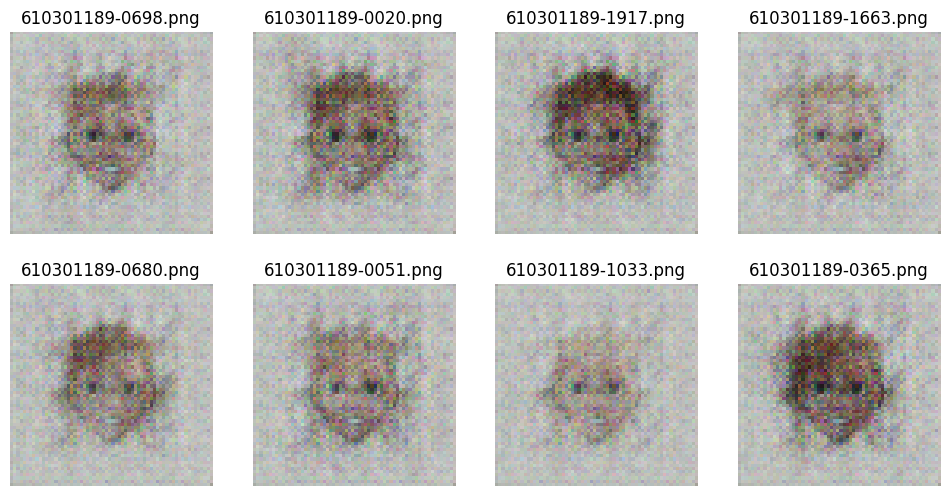

In [ ]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_generated_images(folder_path):
    images = glob.glob(f"{folder_path}/*.png")[:8] # Show first 8
    plt.figure(figsize=(12, 6))
    for i, img_path in enumerate(images):
        img = mpimg.imread(img_path)
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(img_path))
    plt.show()

show_generated_images(config['system']['student_id'])

The generated images show typical early-stage GAN behavior: rough facial features with high-frequency noise and lack of sharp details. The model has learned basic face placement. Furthermore, it can generate variaty in simple features such as hair or face color. However, has not yet captured detailed textures or structures.

1. **Overfitting**: The small dataset (1000 images) and 10 epochs aren't enough to train the GAN fully, leading to noisy, blurry outputs.Due to Colab resource limitations, we were unable to train the model with more data or for additional epochs.
2. **Discriminator Dominance**: The discriminator (Loss_D <<< Loss_G) is overpowering the generator, causing the generator to produce low-quality samples with high variance.
3. **RL Agent Not in Use**: These images are generated using random latent vectors, not the RL agent, meaning diversity from the agent is not being enforced yet.


#### **Saving the Generated Images and Trained Model Weights to *My Google Drive***

- To have access to the images: <a href="https://drive.google.com/drive/folders/1dpSKXJ4LvzXpIDXqS6pQNzCU2gXiZFPQ?usp=sharing"> Link </a>
- To have access to the model weights: <a href="https://drive.google.com/drive/folders/1Qm-Wva1TIN-R2o6KAjnWxEvhSzW5ndoS?usp=sharing"> Link </a>

In [ ]:
!cp -r "/content/610301189" "/content/drive/MyDrive/GAN/610301189"
!cp -r "/content/model_artifacts" "/content/drive/MyDrive/GAN/model_artifacts"